In [203]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from k_means_constrained import KMeansConstrained
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Use the pre-trained Google News corpus (3 billion running words) word vector model

In [204]:
def create_word2vec_model():
    word2vec_path = 'GoogleNews-vectors-negative300.bin' # 3 GB file (not included in repo)
    w2v_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
    return w2v_model

Create a list of connections games from the connections.csv

In [205]:
def create_connections_games():
    df = pd.read_csv('connections.csv', names=['word0', 'word1', 'word2', 'word3', 'clue']).iloc[1:]
    df = df[['word0', 'word1', 'word2', 'word3']]
    words_list = df.stack().tolist()
    words_list = [s.lower() for s in words_list]
    games = [words_list[i:i+16] for i in range(0, len(words_list), 16)]
    return games


Create word embeddings

In [206]:
def create_w2v_embeddings(w2v_model, games):
    embeddings = []
    not_modeled = set()
    for i, word_set in enumerate(games):
        embeddings.append([])
        for word in word_set:
            if word in w2v_model:
                embeddings[i].append(w2v_model[word])
        if len(embeddings[i]) != len(word_set):
            not_modeled.add(i)

    np_embeddings = []
    for word_set in embeddings:
        np_embeddings.append(np.array(word_set))
    
    return np_embeddings, not_modeled

Performs K means clustering for one game

In [207]:
def kmeans_clustering(X, game, visualize=False):
    kmeans_cluster = KMeansConstrained(n_clusters=4, size_min=4, size_max=4)
    cluster_labels = kmeans_cluster.fit_predict(X)
    sil_score = silhouette_score(X, cluster_labels)
    clusters = {}
    for i, word in enumerate(game):
        cluster_label = cluster_labels[i]
        if cluster_label not in clusters:
            clusters[cluster_label] = []
        clusters[cluster_label].append(word)
    clusters = dict(sorted(clusters.items()))

    if visualize:
        visualize_kmeans(X, game, cluster_labels)

    return clusters, sil_score 

In [208]:
def visualize_kmeans(X, game, cluster_labels):
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    for cluster_label in np.unique(cluster_labels):
        plt.scatter(X_reduced[cluster_labels == cluster_label, 0], X_reduced[cluster_labels == cluster_label, 1], 
        label=f'Cluster {cluster_label+1}', alpha=0.5)

    for i, word in enumerate(game):
        plt.annotate(word, (X_reduced[i, 0], X_reduced[i, 1]))

    plt.title('Kmeans Clustering - PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.savefig('K-means_clustering_pca.png')

Plays all the connections games

In [209]:
def play_connections(connections_games, word_embeddings, not_modeled):
    game_results = []
    avg_silhouette_score = 0
    for i, game in enumerate(connections_games):
        if i not in not_modeled:
            clusters, sil_score = kmeans_clustering(word_embeddings[i], game)
            game_results.append(clusters)
            avg_silhouette_score += sil_score
        else:
            game_results.append([])
    avg_silhouette_score = avg_silhouette_score/(len(connections_games)-len(not_modeled))
    return game_results, avg_silhouette_score

Evaluate results of K means

In [210]:
def evaluate_connections(connections_games, results, not_modeled):
    all_correct = 0
    two_correct = 0
    one_correct = 0

    for i, game in enumerate(connections_games):
        if i in not_modeled:
            continue

        result = results[i]
        
        true_list = []
        for i in range(len(game)):
            if i % 4 == 0:
                true_list.append(set())
            true_list[i//4].add(game[i])
        
        pred_list = []
        values = result.values()
        for value in values:
            pred_list.append(set(value))

        match_set_count = 0
        for true_set in true_list:
            if true_set in pred_list:
                match_set_count += 1
        
        if match_set_count >= 1:
            one_correct += 1
            if match_set_count >= 2:
                two_correct += 1
                if match_set_count == 4:
                    all_correct += 1
        
    total_games = len(connections_games) - len(not_modeled)
    print(f"All Correct Group Accuracy: {all_correct / total_games}")
    print(f"Two Correct Group Accuracy: {two_correct / total_games}")  
    print(f"One Correct Group Accuracy : {one_correct / total_games}")  

In [211]:
w2v_model = create_word2vec_model()


In [212]:
connections_games = create_connections_games()

In [213]:
word_embeddings, not_modeled = create_w2v_embeddings(w2v_model, connections_games)

In [214]:
results, avg_silhouette_score = play_connections(connections_games, word_embeddings, not_modeled)

In [215]:
evaluate_connections(connections_games, results, not_modeled)
print(f"Average Silhouette Score: {avg_silhouette_score}")

All Correct Group Accuracy: 0.04918032786885246
Two Correct Group Accuracy: 0.12568306010928962
One Correct Group Accuracy : 0.40437158469945356
Average Silhouette Score: 0.040105824456092155


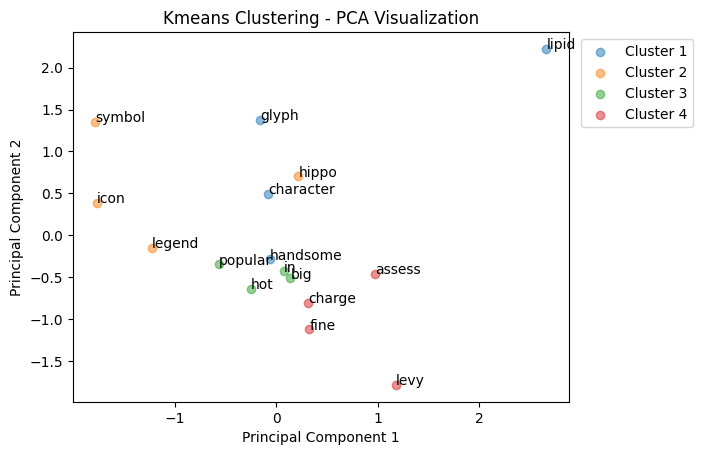

In [216]:
clusters, sil_score = kmeans_clustering(word_embeddings[0], connections_games[0], visualize=True)